---
## Definitions
- Let $\mathcal{A} = \{a_1, \ldots, a_k\}$ be the set of attributes, and let $\mathcal{D}(a_i)$ be the domain of attribute $a_i$.
- A dataset $D = \{r_1, \ldots, r_n\}$ is a set of rows where $r_i \in a_1 \times \ldots \times a_k$ is a tuple of $k$ values and represents one individual in the population.
- Let $\mathcal{S} \subseteq \mathcal{A}$ be a subset of attributes. We say that $r_i[\mathcal{S}]$ are the attribute values of the individual $r_i$ for attributes in $\mathcal{S}$, e.g., $r_2[\{\text{age}, \text{education}\}] = (23, Bachelor)$.

Assumptions about the adversary:
  - She knows $D$, $\mathcal{A}$ and all $\mathcal{D}(a_i)$.
  - She has a single target $r_t \in D$ (random person from the population) and knows some quasi-identifiers (QIDs) about the target, i.e., there is a subset of attributes $\mathcal{Q} \subseteq \mathcal{A}$ and she knows $r_t[\mathcal{Q}]$.
  - For re-identification: The adversary is trying to find out which row correspond to her target.
  - For attribute-inference: The adversary is trying to infer the value of a sensitive attribute $a_s \in \mathcal{A}$.

---
## Example dataset
| age | education   | income   |
|-----|-------------|----------|
| 20  | Master      | <10K     |
| 30  | High School | [10K,50K]|
| 30  | High School | <10K     |
| 30  | PhD         | [10K,50K]|
| 30  | PhD         | [10K,50K]|
| 55  | Bachelor    | >50K     |
| 55  | Bachelor    | >50K     |
| 55  | Bachelor    | [10K,50K]|

---
## Re-identification

**Prior vulnerability:** The adversary's chance of re-identifying a random target before observing the data.

Before learning the QIDs of her target the best the adversary can do is to guess one of the $n$ rows, thus her expected probability of guessing correctly the row is

$\begin{equation}
1/n \text{ .}\nonumber
\end{equation}$

In the example the prior vulnerability is $1/ 8$.

**Posterior vulnerability:** The adversary's chance of re-identifying a random target after observing the data.

After the adversary learned $r_t[\mathcal{Q}]$, she will filter all records $\{r_i~:~r_i[\mathcal{Q}] = r_t[\mathcal{Q}]\}$ and from this subset the best she can do is guessing one of the rows. Her expected chance of success is

$\begin{equation}
\frac{1}{n} \sum\limits_{r_t \in D} \frac{1}{|~\{r_i~:~r_i[\mathcal{Q}] = r_t[\mathcal{Q}]\}~|}\nonumber
\end{equation}$

In the example, assume the adversary knows the age and education of her target. So the possible targets are:
- (20, Master)
- (30, High School)
- (30, PhD)
- (55, Bachelor)

The posterior is then $\Large \frac{1 + 2\cdot \frac{1}{2} + 2\cdot \frac{1}{2} + 3\cdot \frac{1}{3}}{8} = \frac{4}{8} = \frac{1}{2}$

---
## Attribute Inference

Assume the sensitive attribute is *income*.

**Prior vulnerability:** The adversary's chance of guessing correctly the sensitive attribute value of a random target before observing the data.

Before learning the QIDs of her target the best she can do is guessing the most frequent attribute value in the dataset, thus her expected probabilty of success is

$\begin{equation}
\max\limits_{v \in \mathcal{D}(a_s)} \frac{|r_i~:~r_i[a_s] = v|}{n}\text{ .}\nonumber
\end{equation}$

In the example, the most frequent income is "[10K,50K]" that appears in 4 records, so the prior vulnerability will be $4/8 = 1/2$.

**Posterior vulnerability:** The adversary's chance of guessing correctly the sensitive attribute value of a random target after observing the data.

After the adversary learned $r_t[\mathcal{Q}]$, she will filter all records $\{r_i:~r_i[\mathcal{Q}] = r_t[\mathcal{Q}]\}$ and from this subset the best she can do is to guess the attribute value with the highest frequency in the subset. Her expected chance of sucess is

$\begin{equation}
\frac{1}{n} \sum\limits_{r_t \in D} \max\limits_{v \in \mathcal{D}(a_s)} \frac{|~\{r_i~:~r_i[\mathcal{Q}] = r_t[\mathcal{Q}]\} \wedge r_i[a_s] = v~|}{|~\{r_i~:~r_i[\mathcal{Q}] = r_t[\mathcal{Q}]\}~|}
\end{equation}$

In the example the posterior vulnerability will be $\Large\frac{1 + 2\cdot \frac{1}{2} + 2\cdot 1 + 3\cdot \frac{2}{3}}{8} = \frac{6}{8} = \frac{3}{4}$.


In [3]:
import pandas as pd
import numpy as np
import infattacks

In [4]:
dataset = pd.DataFrame({
    "age":[20,30,30,30,30,55,55,55],
    "education":["Master", "High School", "High School", "PhD", "PhD", "Bachelor", "Bachelor", "Bachelor"],
    "income":["<10K", "[10K,50K]", "<10K", "[10K,50K]", "[10K,50K]", ">50K", ">50K", "[10K,50K]"]
})

dataset.sort_values(["age", "education"], inplace=True)
dataset.reset_index(inplace=True, drop=True)
dataset = infattacks.Data(dataframe=dataset)
display(dataset.dataframe)

,age,education,income
0,20,Master,<10K
1,30,High School,"[10K,50K]"
2,30,High School,<10K
3,30,PhD,"[10K,50K]"
4,30,PhD,"[10K,50K]"
5,55,Bachelor,>50K
6,55,Bachelor,>50K
7,55,Bachelor,"[10K,50K]"


[Re-identification]
Prior vulnerability: 0.1250
Posterior vulnerability: 0.5000


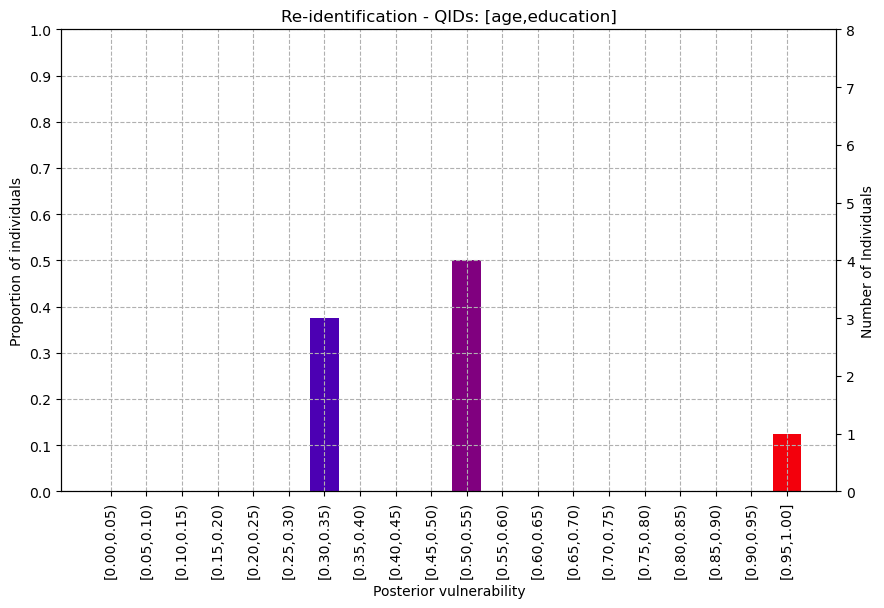


[Attribute-Inference]
Prior vulnerability: 0.5000
Posterior vulnerability: 0.7500


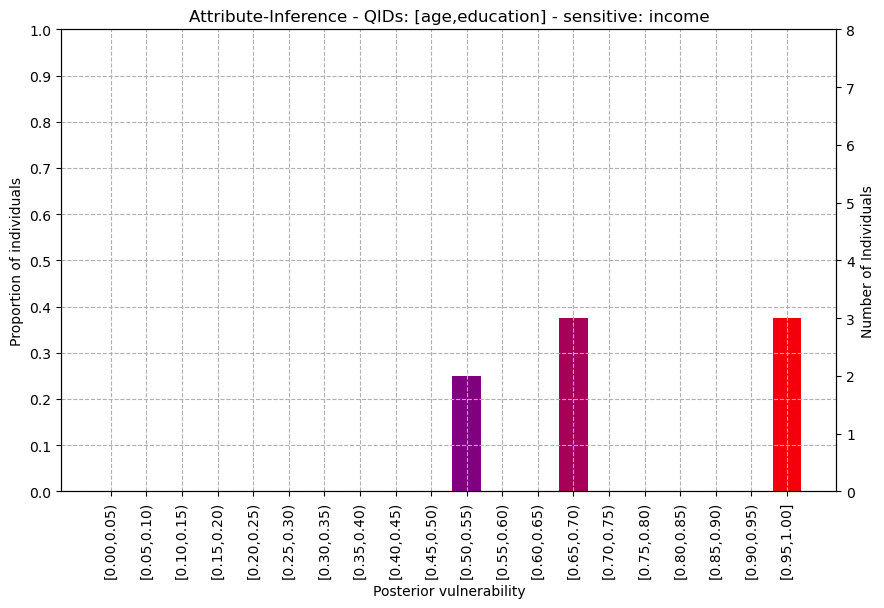

In [3]:
# Attack
qids = ["age", "education"]
sensitive = ["income"]

attack = infattacks.Probabilistic(dataset, qids=qids, sensitive=sensitive)
prior_reid = attack.prior_reid()
prior_ai = attack.prior_ai()
exp_reid, hist_reid = attack.post_reid(qids=qids, hist=True)
exp_ai, hist_ai = attack.post_ai(qids=qids, hist=True)

print("[Re-identification]")
print("Prior vulnerability: %.6f"%(prior_reid))
print("Posterior vulnerability: %.6f"%(exp_reid))

print("\n[Attribute-Inference]")
for att in sensitive:
    print("Prior vulnerability [%s]: %.6f"%(att, prior_ai[att]))
    print("Posterior vulnerability [%s]: %.6f"%(att, exp_ai[att]))

vis = infattacks.VisualizeRisk(attack)
vis.plot_hist(hist_reid, "Re-identification - QIDs: [age,education]")
vis.plot_hist(hist_ai["income"], "Attribute-Inference - QIDs: [age,education] - sensitive: income")